# Plots
This notebook contains all the plots used in the slides. These are all generated using Matplotlib.

In [3]:
# import packages and modules
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import table
from ucimlrepo import fetch_ucirepo

# loading the iris dataset
iris = load_iris()


## Table

## Loss

Starting training...
Generating loss landscape...


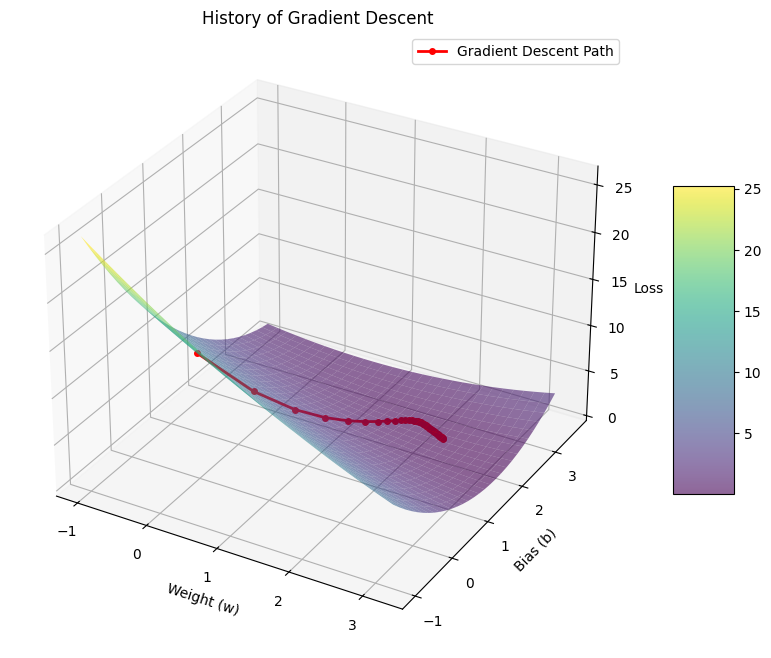

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Setup Data (Synthetic Linear Data) ---
# Function: y = 3x + 2 + noise
X = torch.rand(100, 1)
Y = 3 * X + 2 + 0.1 * torch.randn(100, 1)

# --- 2. Define Parameters (Single Neuron) ---
# We use manual parameters to make tracking them easier
w = torch.tensor([0.0], requires_grad=True) # Weight initialized at 0
b = torch.tensor([0.0], requires_grad=True) # Bias initialized at 0

lr = 0.1
epochs = 50

# Lists to store the history for plotting
w_history = []
b_history = []
loss_history = []

# --- 3. Training Loop (Gradient Descent) ---
print("Starting training...")
for i in range(epochs):
    # Forward pass
    predictions = w * X + b

    # Calculate Loss (MSE)
    loss = ((predictions - Y)**2).mean()

    # Store history (detach from graph for plotting)
    w_history.append(w.item())
    b_history.append(b.item())
    loss_history.append(loss.item())

    # Backward pass
    loss.backward()

    # Update parameters (Standard Gradient Descent)
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

        # Reset gradients
        w.grad.zero_()
        b.grad.zero_()

# --- 4. Generate the "Loss Landscape" Grid ---
# Create a meshgrid around the area our parameters traversed
w_range = np.linspace(min(w_history)-1, max(w_history)+1, 30)
b_range = np.linspace(min(b_history)-1, max(b_history)+1, 30)
W_grid, B_grid = np.meshgrid(w_range, b_range)
Z_grid = np.zeros_like(W_grid)

# Calculate loss for every point on the grid to create the surface
print("Generating loss landscape...")
for i in range(len(w_range)):
    for j in range(len(b_range)):
        w_val = W_grid[i, j]
        b_val = B_grid[i, j]

        # Calculate MSE for this specific coordinate
        # (Using numpy calculation here for speed/simplicity)
        pred_grid = w_val * X.numpy() + b_val
        loss_val = ((pred_grid - Y.numpy())**2).mean()
        Z_grid[i, j] = loss_val

# --- 5. 3D Plotting ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# A. Plot the Surface (The Landscape)
# cmap='viridis' gives a color gradient based on height (loss)
surf = ax.plot_surface(W_grid, B_grid, Z_grid, cmap='viridis', alpha=0.6, edgecolor='none')

# B. Plot the History (The Path)
# We plot this as a distinct red line
ax.plot(w_history, b_history, loss_history, color='red', marker='o', markersize=4, linewidth=2, label='Gradient Descent Path')

# Labels and Styling
ax.set_xlabel('Weight (w)')
ax.set_ylabel('Bias (b)')
ax.set_zlabel('Loss')
ax.set_title('History of Gradient Descent')
ax.legend()
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
from collections import OrderedDict
from torch.nn import functional as F
from torch import nn
import torch
import tqdm
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [15]:

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

/var/folders/jd/rmzvvh4s2jzg55h334m9_q040000gn/T/ipykernel_51300/4031988760.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})


In [16]:
# Convert data into tensors

# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels = labels.squeeze().long()

In [25]:
# model architecture
ANN_model = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,3),   # output layer
      )

# loss function
lossfunc = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANN_model.parameters(),lr=.01)

Generating synthetic data (N=150, Features=4)...


Scanning Seed 51: 100%|██████████| 50/50 [00:00<00:00, 5130.90it/s]


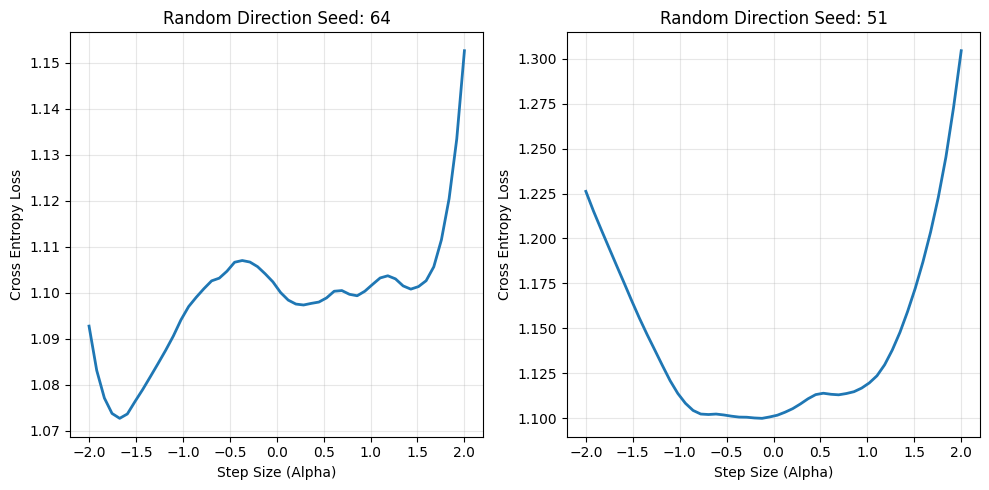

In [54]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import pandas as pd # Added for data simulation if needed

# --- 1. Helper Functions (Unchanged) ---
def get_random_directions(params, seed=42):
    torch.manual_seed(seed)
    directions = {}
    for name, param in params:
        directions[name] = torch.randn_like(param)
    return directions

def normalize_direction(directions, params):
    param_dict = {n: p for n, p in params}
    for name in directions:
        if name in param_dict:
            p_norm = param_dict[name].norm()
            d_norm = directions[name].norm()
            directions[name] = directions[name] * (p_norm / (d_norm + 1e-10))
    return directions

# --- 2. Setup Data and Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NOTE: I am generating synthetic data here to match your shape (4 features, 3 classes).
# If you have your actual X and y loaded, you can skip the generation lines.
print("Generating synthetic data (N=150, Features=4)...")
X_dummy = np.random.randn(150, 4)
y_dummy = np.random.randint(0, 3, size=(150,))

# Convert to tensors (using your snippet's logic)
data = torch.tensor(X.values).float().to(device)
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels = labels.squeeze().long().to(device) # CrossEntropy expects LongTensor (integers)

# --- 3. Define Your Custom Model ---
ANN_model = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,3),   # output layer
).to(device)

# Loss function (CrossEntropy for classification)
lossfunc = nn.CrossEntropyLoss()

# --- 4. Plotting Loop ---
fig = plt.figure(figsize=(10, 5))

# We will plot two different random directions (seeds)
for fig_count, random_seed in enumerate([64, 51]):

    # A. Get Parameters
    # Note: Removed [1:] slice. For simple ANNs, we usually want to visualize
    # the first layer (Input->Hidden) as well.
    filtered_params = [(name, p) for name, p in ANN_model.named_parameters() if p.requires_grad]

    # B. Generate Random Directions
    direction1 = get_random_directions(filtered_params, seed=random_seed)
    direction1 = normalize_direction(direction1, filtered_params)

    # C. Store Original Weights
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()

    # D. Define Scan Range
    num_points = 50
    alphas = np.linspace(-2.0, 2.0, num_points) # Range of the slice
    losses = []

    # E. The Visualization Loop
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas, desc=f"Scanning Seed {random_seed}")):

            # 1. Perturb Weights
            for name, param in ANN_model.named_parameters():
                if name in direction1:
                    param.data = original_params[name] + alpha * direction1[name]

            # 2. Forward Pass
            # Pass the WHOLE dataset (or a large batch) to get the loss for this landscape point
            outputs = ANN_model(data)

            # 3. Calculate Loss
            # Using your specific lossfunc (CrossEntropyLoss)
            loss_val = lossfunc(outputs, labels).item()
            losses.append(loss_val)

        # F. Restore Original Parameters
        # Crucial: Reset model so the next seed starts from the same place
        for name, param in ANN_model.named_parameters():
            if name in original_params:
                param.data.copy_(original_params[name])

    # F. Plot
    ax = fig.add_subplot(1, 2, fig_count + 1)
    ax.plot(alphas, losses, linewidth=2)
    ax.set_xlabel('Step Size (Alpha)')
    ax.set_ylabel('Cross Entropy Loss')
    ax.set_title(f'Random Direction Seed: {random_seed}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2D/3D Loss Landscape

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

# --- 1. Setup Model and Data (Same as before) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple MLP
model = nn.Sequential(
    OrderedDict([
        ('layer1', nn.Linear(10, 50)),
        ('activation', nn.ReLU()),
        ('layer2', nn.Linear(50, 1))
    ])
).to(device)

# Dummy inputs and targets
input_tensor = torch.randn(1, 10).to(device)
target_value = torch.tensor([[5.0]]).to(device)
criterion = nn.MSELoss()

# --- 2. Generate Random Directions ---
# REMOVED: "if i < 64" logic.
# Since this model is small, we can generate directions for ALL parameters
# without running out of VRAM.
direction1 = [torch.randn_like(p) for p in model.parameters()]
direction2 = [torch.randn_like(p) for p in model.parameters()]

# --- 3. Filter-wise Normalization ---
# This ensures that layers with small weights get small perturbations,
# and layers with large weights get large perturbations.
for p, d1, d2 in zip(model.parameters(), direction1, direction2):
    norm_p = torch.linalg.norm(p.flatten())

    # Avoid division by zero with +1e-10
    d1.div_(torch.linalg.norm(d1.flatten()) + 1e-10).mul_(norm_p)
    d2.div_(torch.linalg.norm(d2.flatten()) + 1e-10).mul_(norm_p)


In [ ]:

# --- 4. Define the Grid ---
resolution = 512 # 25x25 = 625 forward passes. Increase for smoother plots.
x = np.linspace(-2.5, 2.5, resolution)
y = np.linspace(-2.5, 2.5, resolution)
X, Y = np.meshgrid(x, y)

# Prepare to collect the losses
Z = np.zeros_like(X)
model.eval()

# --- 5. The Main Loop (Perturb -> Measure -> Revert) ---
print(f"Computing loss surface ({resolution}x{resolution})...")
model = torch.compile(model)
for i in tqdm(range(len(x))):
    for j in range(len(y)):
        # We calculate the perturbation amounts once per coordinate
        # alpha = x[i], beta = y[j]

        with torch.no_grad():
            # A. Apply Perturbation
            # We add (alpha * direction1) + (beta * direction2) to current weights
            for p, d1, d2 in zip(model.parameters(), direction1, direction2):
                p.data.add_(x[i] * d1 + y[j] * d2)

            # B. Compute Loss
            # REPLACED: HuggingFace interface with standard forward pass
            outputs = model(input_tensor)
            loss = criterion(outputs, target_value)
            Z[i, j] = loss.item()

            # C. Revert Parameters
            # Subtract the exact same amount to return to the center
            for p, d1, d2 in zip(model.parameters(), direction1, direction2):
                p.data.sub_(x[i] * d1 + y[j] * d2)

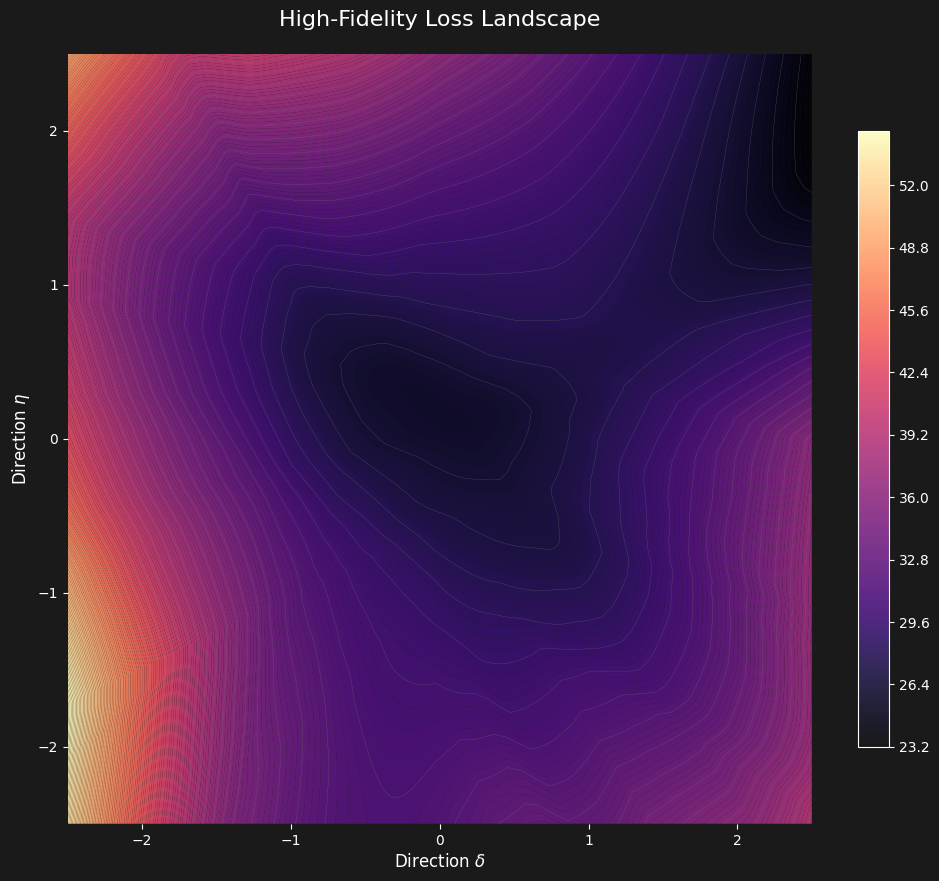

In [22]:
fig, ax = plt.subplots(figsize=(12, 10)) # Larger canvas

# Dark Theme Setup
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

# 1. High-count Levels for smooth gradients (Visual Trick)
# even if your grid is only 50x50, levels=200 makes it look like 1000x1000
contourf = ax.contourf(X, Y, Z, levels=200, cmap='magma', alpha=0.9, antialiased=True)

# 2. Thinner, more frequent contour lines
contour = ax.contour(X, Y, Z, levels=50, colors='white', linewidths=0.2, alpha=0.3)

# 4. Minimalist styling
ax.set_title('High-Fidelity Loss Landscape', color='white', fontsize=16, pad=20)
ax.set_xlabel('Direction $\delta$', color='white', fontsize=12)
ax.set_ylabel('Direction $\eta$', color='white', fontsize=12)
ax.tick_params(axis='both', colors='white', which='both')

# Remove the box spine for a cleaner "modern" look
for spine in ax.spines.values():
    spine.set_visible(False)

# Save high quality
plt.savefig('high_res_dark.png', dpi=400, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()

In [64]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import copy
from collections import OrderedDict

# --- 1. Configuration & Setup ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Config for the run
output_dir = './loss_data_ann'
num_points = 512         # Resolution (25x25) - Lowered slightly for speed as model is deeper
n_steps = 10           # How many training steps to run
lr = 0.05               # Learning rate (Higher for SGD usually)
delayed_viz_start = 0
viz_frequency = 10

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# --- 2. Define Model (Your ANN_model) ---
# We wrap it in a class or Sequential.
# Using default Sequential here implies parameter names will be "0.weight", "2.weight", etc.
model = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,3),   # output layer
).to(device)

# --- 3. Define Data (Synthetic Classification) ---
# We need a BATCH of data to get a stable landscape, not just one point.
# 150 samples, 4 features
# inputs = torch.randn(150, 4).to(device)
# # Targets: Integers 0, 1, or 2
# target = torch.randint(0, 3, (150,)).to(device)
inputs = data
target = labels

# Define Loss Function (CrossEntropy for 3 classes)
criterion = nn.CrossEntropyLoss()

# --- 4. Pre-Training (Find the "Center") ---
# We train the model to fit this synthetic batch perfectly first.
print("Pre-training model to create a 'Center' (Minimum)...")
optimizer_pre = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for i in range(200): # Give it enough steps to converge
    optimizer_pre.zero_grad()
    out = model(inputs)
    loss = criterion(out, target)
    loss.backward()
    optimizer_pre.step()

print(f"Pre-trained Loss (The Target Minimum): {loss.item():.6f}")

# --- 5. Support Functions ---
def get_random_directions(params, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    return direction

def normalize_direction(direction, params):
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    return normalized_direction

# --- 6. Prepare Directions & Grid ---
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]

random_seed_1 = 42
random_seed_2 = 123

direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction2 = get_random_directions(filtered_params, seed=random_seed_2)
direction1 = normalize_direction(direction1, filtered_params)
direction2 = normalize_direction(direction2, filtered_params)

# Save the "Optimal" parameters (Coordinate 0,0)
original_optimal_params = OrderedDict()
for name, param in filtered_params:
    original_optimal_params[name] = param.data.clone()

# Define grid range
alphas = np.linspace(-1.5, 1.5, num_points)
betas = np.linspace(-1.5, 1.5, num_points)

# --- 7. Shift Start Position ---
# Move parameters AWAY from the minimum to simulate a random initialization
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

alpha_shift = -0.8
beta_shift = 0.5

print(f"Shifting model weights by alpha={alpha_shift}, beta={beta_shift}...")
for name, param in model.named_parameters():
    if name in direction1 and name in direction2:
        param.data = original_optimal_params[name] + alpha_shift * direction1[name] + beta_shift * direction2[name]

# Save this "Bad" starting state
current_params_snapshot = OrderedDict()
for name, param in filtered_params:
    current_params_snapshot[name] = param.data.clone()

# --- 8. Main Visualization Loop ---
model_losses = []

print("Starting visualization loop...")
for step in range(n_steps):

    # A. Check Current Loss
    model.eval()
    with torch.no_grad():
        current_out = model(inputs)
        current_loss = criterion(current_out, target).item()
        model_losses.append(current_loss)
        print(f"Step {step}: Loss = {current_loss:.6f}")

    # B. Render Landscape
    if step >= delayed_viz_start and step % viz_frequency == 0:
        losses = []

        # Scan the grid relative to OPTIMAL parameters (0,0)
        with torch.no_grad():
            for alpha in tqdm(alphas, desc=f"Scanning Step {step}"):
                row_losses = []
                for beta in betas:
                    # Perturb weights
                    for name, param in model.named_parameters():
                        if name in direction1:
                            param.data = original_optimal_params[name] + alpha * direction1[name] + beta * direction2[name]

                    # Compute Loss
                    out = model(inputs)
                    loss_val = criterion(out, target).item()
                    # Log scale for visibility
                    row_losses.append(np.log(loss_val + 1e-9))
                losses.append(row_losses)

            # Restore current training parameters
            for name, param in model.named_parameters():
                if name in current_params_snapshot:
                    param.data.copy_(current_params_snapshot[name])

        # C. Plotting
        losses = np.array(losses)
        np.save(output_dir +'/'+str(step).zfill(3), losses)

        plt.clf()
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot Contours
        contourf = ax.contourf(betas, alphas, losses, levels=20, cmap='viridis', alpha=0.8)
        contour = ax.contour(betas, alphas, losses, levels=30, colors='white', linewidths=0.5)

        # Plot Center (Global Min)
        plt.scatter(0, 0, c='red', marker='x', s=100, label='Global Min (Pre-trained)')

        # Plot Start Point (only on step 0)
        if step == 0:
             plt.scatter(beta_shift, alpha_shift, c='magenta', s=100, label='Start')

        ax.set_title(f"Step {step} - Log CrossEntropy Landscape")
        ax.set_xlabel("Direction 2 (Beta)")
        ax.set_ylabel("Direction 1 (Alpha)")
        plt.legend()
        plt.savefig(f"{output_dir}/step_{str(step).zfill(3)}.png")
        plt.close(fig)

    # C. Training Step
    model.train()
    optimizer.zero_grad()
    out = model(inputs)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    # Update snapshot
    for name, param in filtered_params:
        current_params_snapshot[name] = param.data.clone()

print(f"Done! Images saved to {output_dir}")

Pre-training model to create a 'Center' (Minimum)...
Pre-trained Loss (The Target Minimum): 0.038130
Shifting model weights by alpha=-0.8, beta=0.5...
Starting visualization loop...
Step 0: Loss = 3.688938


Scanning Step 0: 100%|██████████| 512/512 [00:33<00:00, 15.25it/s]


Step 1: Loss = 7.580314
Step 2: Loss = 3.465577
Step 3: Loss = 1.854330
Step 4: Loss = 1.868817
Step 5: Loss = 0.318360
Step 6: Loss = 0.601690
Step 7: Loss = 1.156188
Step 8: Loss = 1.091875
Step 9: Loss = 0.673876
Done! Images saved to ./loss_data_ann


<Figure size 640x480 with 0 Axes>

### Plotting

Loading loss landscape from step 0...


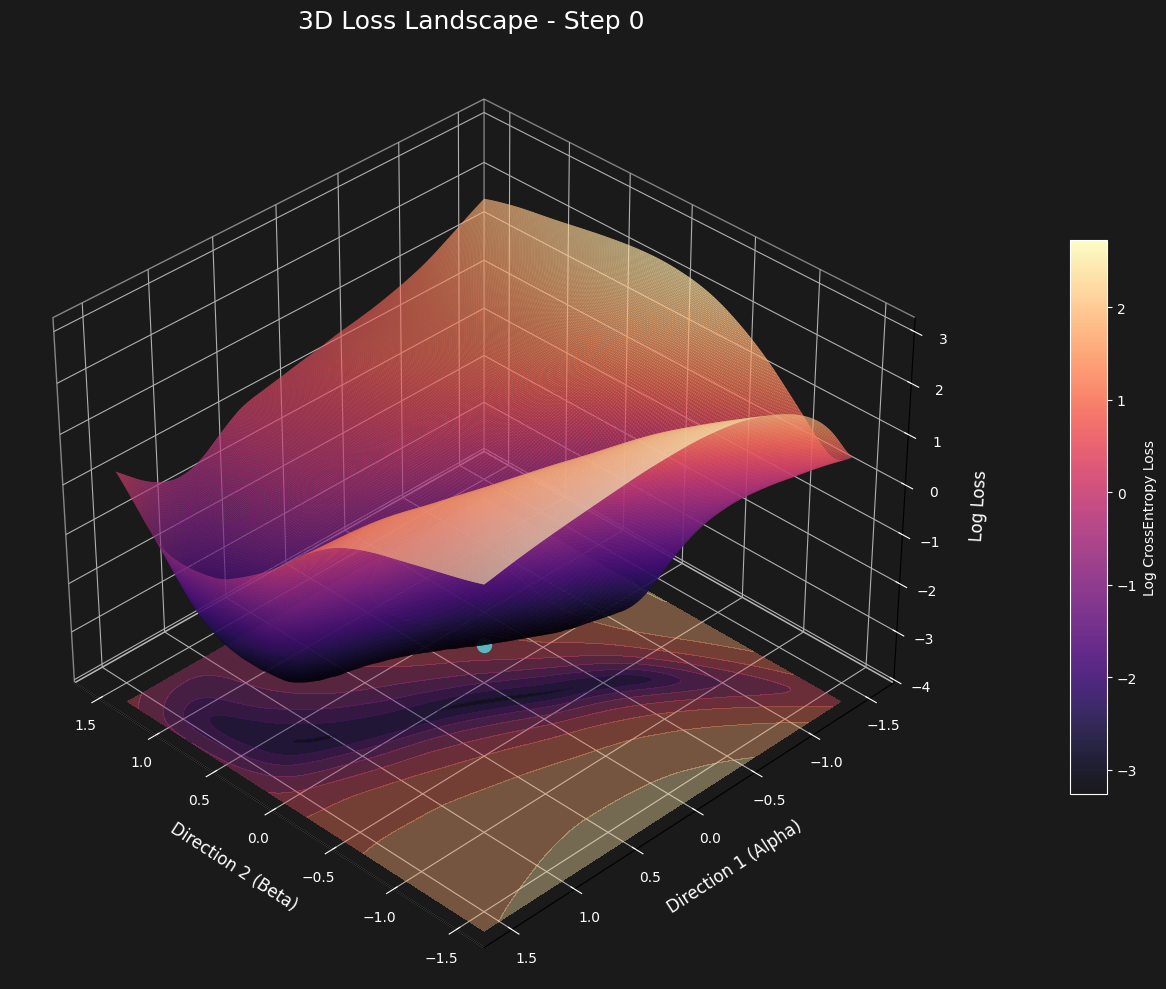

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# --- 1. Configuration (Must match your generation script) ---
output_dir = './loss_data_ann' # Directory where files were saved
step_to_visualize = 0          # Change this to view different steps (0, 10, 20, etc.)
num_points = 512                # Resolution used in generation
grid_range = 1.5               # Range used in generation (-1.5 to 1.5)

# Filename construction (e.g., ./loss_data_ann/000.npy)
filename = os.path.join(output_dir, f"{str(step_to_visualize).zfill(3)}.npy")

# --- 2. Load Data and Reconstruct Grid ---
if not os.path.exists(filename):
    print(f"Error: File {filename} not found. Did you run the generation script?")
else:
    print(f"Loading loss landscape from step {step_to_visualize}...")

    # Load the Z-axis (Loss values)
    Z = np.load(filename)

    # Reconstruct the X and Y axes (Alphas and Betas)
    alphas = np.linspace(-grid_range, grid_range, num_points)
    betas = np.linspace(-grid_range, grid_range, num_points)

    # Create 2D coordinate mesh
    # Note: meshgrid order matters to match the [alpha][beta] nesting of the saved array
    # We map Beta to X-axis and Alpha to Y-axis to match previous labels
    B_grid, A_grid = np.meshgrid(betas, alphas)

    # --- 3. High-Fidelity 3D Plotting ---
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # A. Dark Theme Setup
    bg_color = '#1a1a1a'
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # Remove gray panes for a clean look
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(color='white', linestyle='--', alpha=0.15)

    # B. Plot Surface
    # cmap='magma' or 'inferno' looks best on dark backgrounds
    surf = ax.plot_surface(B_grid, A_grid, Z, cmap='magma',
                           edgecolor='none', alpha=0.9, antialiased=True, rstride=1, cstride=1)

    # C. Add "Floor" Shadow Projection
    # Project the contour onto the bottom of the graph to help gauge depth
    z_min = np.min(Z)
    z_range = np.max(Z) - z_min
    offset = z_min - (z_range * 0.2) # Place shadow 20% below the lowest point

    ax.contourf(B_grid, A_grid, Z, zdir='z', offset=offset, cmap='magma', alpha=0.4)

    # D. Markers
    # Mark the center (0,0) which is the Pre-Trained Global Minimum
    center_loss = Z[num_points//2, num_points//2] # Approximate center index
    ax.scatter(0, 0, center_loss, color='cyan', s=100, label='Global Min (Center)', zorder=10)

    # E. Styling Labels
    ax.set_title(f'3D Loss Landscape - Step {step_to_visualize}', color='white', size=18, pad=20)
    ax.set_xlabel('Direction 2 (Beta)', color='white', fontsize=12, labelpad=10)
    ax.set_ylabel('Direction 1 (Alpha)', color='white', fontsize=12, labelpad=10)
    ax.set_zlabel('Log Loss', color='white', fontsize=12, labelpad=10)

    # Set axis tick colors to white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.tick_params(axis='z', colors='white')

    # F. Final View Adjustments
    # ax.set_zlim(offset, np.max(Z)) # Ensure the shadow is visible
    ax.view_init(elev=35, azim=135) # Optimal viewing angle

    # Add a color bar
    cbar = fig.colorbar(surf, shrink=0.6, aspect=15, pad=0.1)
    cbar.set_label('Log CrossEntropy Loss', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    cbar.outline.set_edgecolor('white')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/step_3d_{str(step_to_visualize).zfill(3)}.png")
    plt.show()

Loading 2D landscape from step 0...


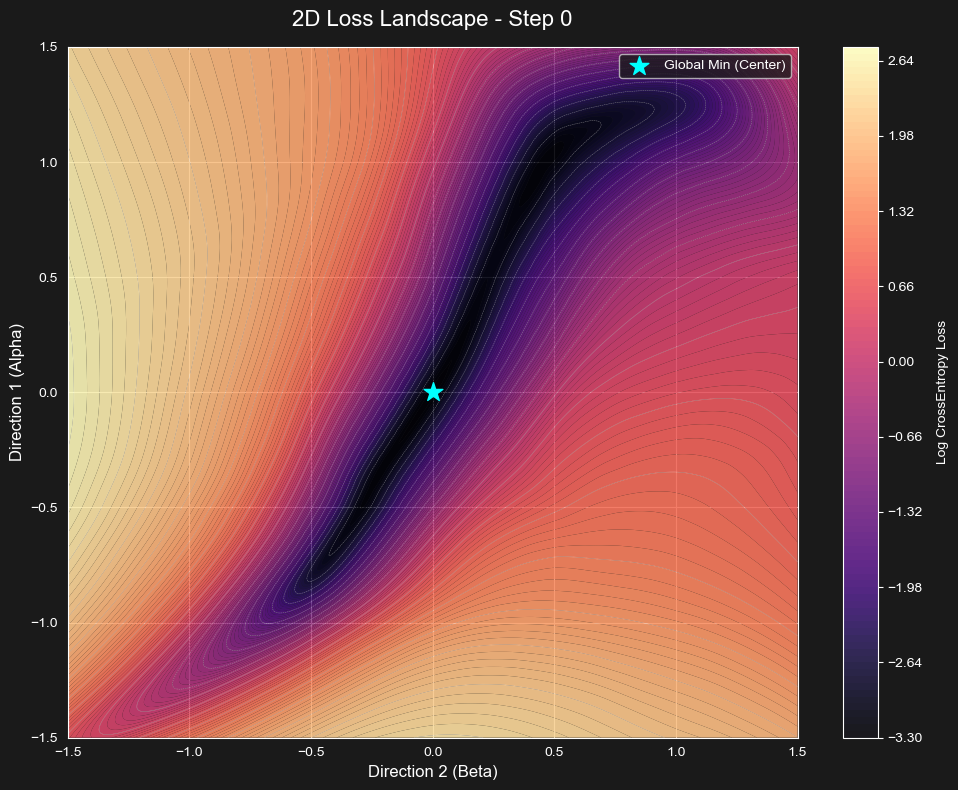

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Configuration ---
output_dir = './loss_data_ann' # Directory where files were saved
step_to_visualize = 0          # Change this to view different steps
num_points = 512                # Resolution used in generation
grid_range = 1.5               # Range used in generation (-1.5 to 1.5)

# Construct filename
filename = os.path.join(output_dir, f"{str(step_to_visualize).zfill(3)}.npy")

# --- 2. Load and Prep Data ---
if not os.path.exists(filename):
    print(f"Error: File {filename} not found.")
else:
    print(f"Loading 2D landscape from step {step_to_visualize}...")

    # Load Z (Loss Matrix)
    Z = np.load(filename)

    # Reconstruct X (Beta) and Y (Alpha) axes
    alphas = np.linspace(-grid_range, grid_range, num_points)
    betas = np.linspace(-grid_range, grid_range, num_points)

    # --- 3. Plotting (Dark Mode 2D) ---
    fig, ax = plt.subplots(figsize=(10, 8))

    # A. Dark Theme Background
    bg_color = '#1a1a1a'
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # B. Contour Fill (The Heatmap)
    # levels=100 creates a very smooth gradient
    # antialiased=True prevents pixelated edges
    contourf = ax.contourf(betas, alphas, Z, levels=100, cmap='magma', alpha=0.9, antialiased=True)

    # C. Contour Lines (The Elevation Lines)
    # Thin white lines to show steepness
    contour = ax.contour(betas, alphas, Z, levels=20, colors='white', linewidths=0.3, alpha=0.5)

    # D. Markers
    # Mark the "Center" (The Pre-Trained Minimum)
    ax.scatter(0, 0, c='cyan', marker='*', s=200, label='Global Min (Center)', zorder=10)

    # E. Styling
    ax.set_title(f'2D Loss Landscape - Step {step_to_visualize}', color='white', size=16, pad=15)
    ax.set_xlabel('Direction 2 (Beta)', color='white', fontsize=12)
    ax.set_ylabel('Direction 1 (Alpha)', color='white', fontsize=12)

    # Tick colors
    ax.tick_params(colors='white', which='both')

    # Border (Spine) colors
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    # F. Colorbar
    cbar = fig.colorbar(contourf)
    cbar.set_label('Log CrossEntropy Loss', color='white', labelpad=10)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    cbar.outline.set_edgecolor('white')

    plt.legend(facecolor=bg_color, labelcolor='white', loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/step_2d_{str(step_to_visualize).zfill(3)}.png", dpi=1000)
    plt.show()

Loading ./loss_data_ann/000.npy...


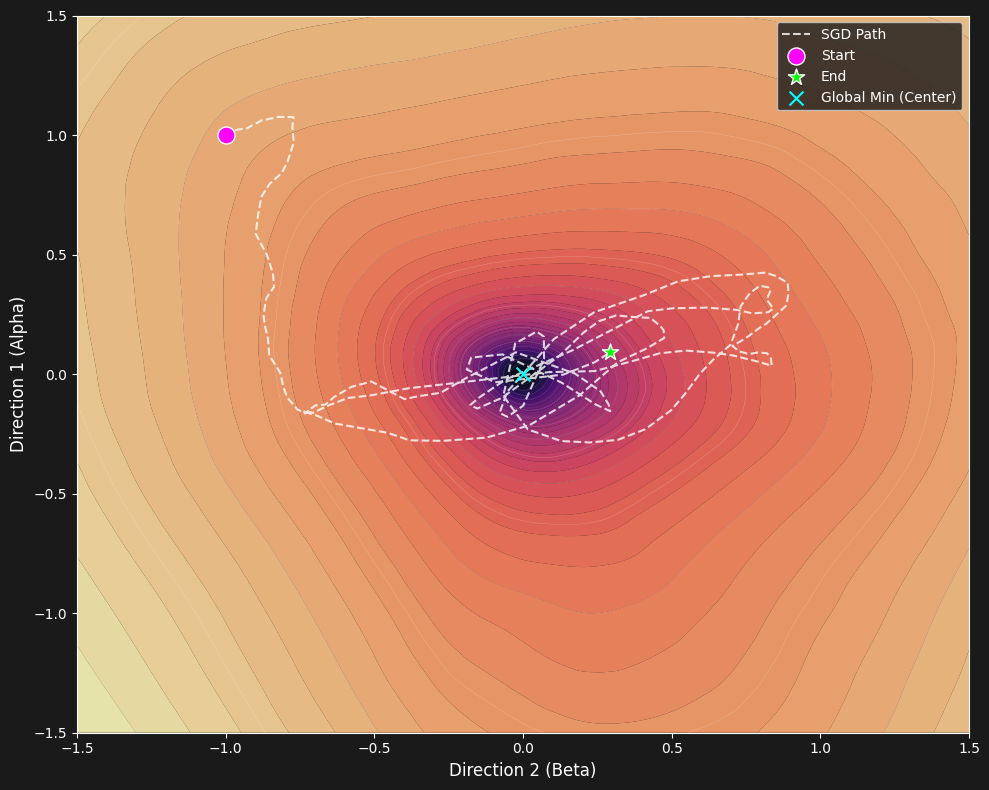

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Configuration ---
output_dir = './loss_data_ann' # Directory with your .npy files
step_to_load = 0               # Which snapshot to use as the background
num_points = 512               # MUST match your generation resolution
grid_range = 1.5               # MUST match your generation range (-1.5 to 1.5)

filename = os.path.join(output_dir, f"{str(step_to_load).zfill(3)}.npy")

# --- 2. Load Data ---
if not os.path.exists(filename):
    # Fallback for testing if file doesn't exist
    print("File not found, generating dummy 512x512 landscape...")
    x = np.linspace(-grid_range, grid_range, num_points)
    X, Y = np.meshgrid(x, x)
    Z = np.sin(3*X) + np.cos(3*Y) + 0.5 * (X**2 + Y**2)
else:
    print(f"Loading {filename}...")
    Z = np.load(filename)

# Create axes for plotting
alphas = np.linspace(-grid_range, grid_range, num_points)
betas = np.linspace(-grid_range, grid_range, num_points)

def simulate_2d_path(Z_matrix, start_alpha, start_beta, steps=200, seed=42):
    # 1. SET SEED
    if seed is not None:
        np.random.seed(seed)

    path_alpha = [start_alpha]
    path_beta = [start_beta]

    alpha_curr, beta_curr = start_alpha, start_beta
    velocity_alpha, velocity_beta = 0.0, 0.0

    # Physics Tuning for 512 Grid
    momentum = 0.90
    gravity = 0.02
    noise = 0.02 # Visible jitter

    for _ in range(steps):
        # BOUNDARY CHECK
        if (abs(alpha_curr) >= grid_range * 0.98) or (abs(beta_curr) >= grid_range * 0.98):
            break

        # Indices
        r = int((alpha_curr + grid_range) / (2*grid_range) * (num_points - 1))
        c = int((beta_curr + grid_range) / (2*grid_range) * (num_points - 1))
        r = max(0, min(num_points - 2, r))
        c = max(0, min(num_points - 2, c))

        # Gradients (Boosted)
        grad_alpha = (Z_matrix[r+1, c] - Z_matrix[r, c]) * 50
        grad_beta  = (Z_matrix[r, c+1] - Z_matrix[r, c]) * 50

        # Physics Update
        velocity_alpha = momentum * velocity_alpha - gravity * grad_alpha + np.random.randn()*noise
        velocity_beta = momentum * velocity_beta - gravity * grad_beta + np.random.randn()*noise

        alpha_curr += velocity_alpha
        beta_curr += velocity_beta

        path_alpha.append(alpha_curr)
        path_beta.append(beta_curr)

    return path_beta, path_alpha # Returns X, Y

# --- 4. Run Simulation ---
# Start near top-left (adjust as needed to be "on a hill")
sim_beta, sim_alpha = simulate_2d_path(Z, start_alpha=1.0, start_beta=-1.0, steps=150)

# --- 5. Plotting (Dark Mode) ---
fig, ax = plt.subplots(figsize=(10, 8))

# Dark Background
bg_color = '#1a1a1a'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

# A. The Contour Map (Background)
# levels=50 for smooth gradients on 512x512
contourf = ax.contourf(betas, alphas, Z, levels=50, cmap='magma', alpha=0.9, antialiased=True)
# Thin lines
ax.contour(betas, alphas, Z, levels=20, colors='white', linewidths=0.3, alpha=0.3)

# B. The Simulated Path
# White dashed line for trajectory
ax.plot(sim_beta, sim_alpha, color='white', linestyle='--', linewidth=1.5, label='SGD Path', alpha=0.8)

# C. Markers
# Start (Magenta)
ax.scatter(sim_beta[0], sim_alpha[0], c='magenta', s=150, marker='o', label='Start', zorder=10, edgecolors='white')
# End (Lime)
ax.scatter(sim_beta[-1], sim_alpha[-1], c='lime', s=150, marker='*', label='End', zorder=10, edgecolors='white')
# Global Min (Cyan Cross) - The center of your grid
ax.scatter(0, 0, c='cyan', marker='x', s=100, label='Global Min (Center)', zorder=9)

# D. Styling
# ax.set_title(f'Simulated Optimization Trajectory (2D)', color='white', size=16, pad=15)
ax.set_xlabel('Direction 2 (Beta)', color='white', fontsize=12)
ax.set_ylabel('Direction 1 (Alpha)', color='white', fontsize=12)
ax.tick_params(colors='white', which='both')
for spine in ax.spines.values(): spine.set_edgecolor('white')

# Colorbar
# cbar = fig.colorbar(contourf)
# cbar.set_label('Loss', color='white')
# cbar.ax.yaxis.set_tick_params(color='white')
# cbar.outline.set_edgecolor('white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.legend(facecolor=bg_color, labelcolor='white', loc='upper right')
plt.tight_layout()
plt.show()

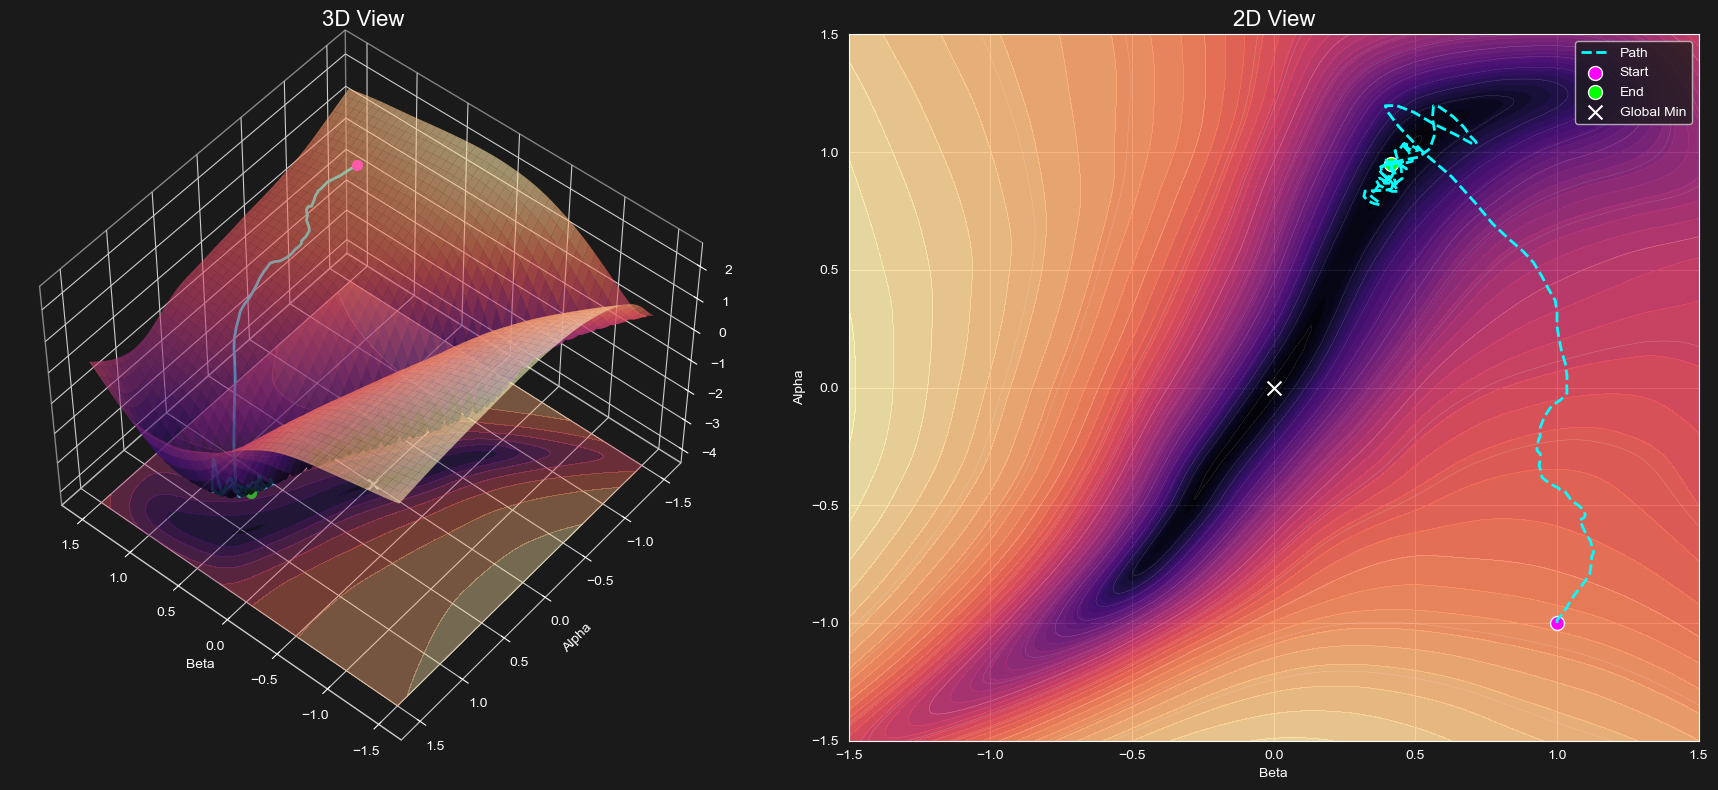

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# --- 1. Configuration ---
output_dir = './loss_data_ann'
step_to_load = 0
num_points = 512       # Must match generation
grid_range = 1.5       # Must match generation

filename = os.path.join(output_dir, f"{str(step_to_load).zfill(3)}.npy")

# Load Data
if not os.path.exists(filename):
    print("File not found, generating dummy data...")
    x = np.linspace(-grid_range, grid_range, num_points)
    X, Y = np.meshgrid(x, x)
    Z = np.sin(3*X) + np.cos(3*Y)
else:
    Z = np.load(filename)

alphas = np.linspace(-grid_range, grid_range, num_points)
betas = np.linspace(-grid_range, grid_range, num_points)
B_grid, A_grid = np.meshgrid(betas, alphas)

# --- 2. The Shared Physics Engine ---
def get_physics_path(Z_matrix, start_alpha, start_beta, steps=200, seed=42):
    """
    Returns (path_beta, path_alpha, path_z)
    Calculates the path ONCE so it's consistent across all plots.
    """
    if seed is not None:
        np.random.seed(seed)

    # Helper for Z lookup
    def get_z(a, b):
        r = int((a + grid_range) / (2*grid_range) * (num_points - 1))
        c = int((b + grid_range) / (2*grid_range) * (num_points - 1))
        r = max(0, min(num_points - 1, r))
        c = max(0, min(num_points - 1, c))
        return Z_matrix[r, c]

    path_alpha = [start_alpha]
    path_beta = [start_beta]
    path_z = [get_z(start_alpha, start_beta) + 0.05]

    alpha_curr, beta_curr = start_alpha, start_beta
    vel_alpha, vel_beta = 0.0, 0.0

    # --- SHARED PHYSICS CONSTANTS ---
    momentum = 0.90
    gravity = 0.02
    noise = 0.01

    for _ in range(steps):
        # Boundary Check
        if (abs(alpha_curr) >= grid_range * 0.98) or (abs(beta_curr) >= grid_range * 0.98):
            break

        # Indices
        r = int((alpha_curr + grid_range) / (2*grid_range) * (num_points - 1))
        c = int((beta_curr + grid_range) / (2*grid_range) * (num_points - 1))
        r = max(0, min(num_points - 2, r))
        c = max(0, min(num_points - 2, c))

        # Gradients (Boosted for high-res)
        grad_alpha = (Z_matrix[r+1, c] - Z_matrix[r, c]) * 50
        grad_beta  = (Z_matrix[r, c+1] - Z_matrix[r, c]) * 50

        # Update
        vel_alpha = momentum * vel_alpha - gravity * grad_alpha + np.random.randn()*noise
        vel_beta = momentum * vel_beta - gravity * grad_beta + np.random.randn()*noise

        alpha_curr += vel_alpha
        beta_curr += vel_beta

        path_alpha.append(alpha_curr)
        path_beta.append(beta_curr)
        path_z.append(get_z(alpha_curr, beta_curr) + 0.05)

    return path_beta, path_alpha, path_z

# --- 3. Generate the Path ---
# We run this ONCE. Both plots will use these exact variables.
sim_beta, sim_alpha, sim_z = get_physics_path(Z, start_alpha=-1.0, start_beta=1.0, steps=150, seed=42)

# --- 4. Plotting Side-by-Side ---
fig = plt.figure(figsize=(18, 8))

# Dark Theme
bg_color = '#1a1a1a'
fig.patch.set_facecolor(bg_color)

# === LEFT PLOT: 3D Surface ===
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_facecolor(bg_color)
ax1.xaxis.pane.fill = False; ax1.yaxis.pane.fill = False; ax1.zaxis.pane.fill = False
ax1.grid(color='white', linestyle='--', alpha=0.1)

# Surface
ax1.plot_surface(B_grid, A_grid, Z, cmap='magma', edgecolor='none', alpha=0.6, antialiased=True)
# Shadow
z_min = np.min(Z); offset = z_min - (np.max(Z) - z_min) * 0.2
ax1.contourf(B_grid, A_grid, Z, zdir='z', offset=offset, cmap='magma', alpha=0.4)

# Path (3D)
ax1.plot(sim_beta, sim_alpha, sim_z, color='cyan', linewidth=2, label='Path')
ax1.scatter(sim_beta[0], sim_alpha[0], sim_z[0], color='magenta', s=50, label='Start')
ax1.scatter(sim_beta[-1], sim_alpha[-1], sim_z[-1], color='lime', s=50, label='End')
ax1.scatter(0, 0, offset, color='white', marker='x', s=50, label='Global Min')

ax1.set_title('3D View', color='white', size=16)
ax1.set_xlabel('Beta', color='white'); ax1.set_ylabel('Alpha', color='white')
ax1.tick_params(colors='white')
ax1.view_init(elev=50, azim=130)
ax1.set_zlim(offset, np.max(Z))

# === RIGHT PLOT: 2D Contour ===
ax2 = fig.add_subplot(122)
ax2.set_facecolor(bg_color)

# Contour
ax2.contourf(betas, alphas, Z, levels=50, cmap='magma', alpha=0.9)
ax2.contour(betas, alphas, Z, levels=15, colors='white', linewidths=0.3, alpha=0.3)

# Path (2D) - Uses EXACT SAME sim_beta/sim_alpha arrays
ax2.plot(sim_beta, sim_alpha, color='cyan', linestyle='--', linewidth=2, label='Path')
ax2.scatter(sim_beta[0], sim_alpha[0], color='magenta', s=100, label='Start', edgecolors='white')
ax2.scatter(sim_beta[-1], sim_alpha[-1], color='lime', s=100, label='End', edgecolors='white')
ax2.scatter(0, 0, color='white', marker='x', s=100, label='Global Min')

ax2.set_title('2D View', color='white', size=16)
ax2.set_xlabel('Beta', color='white'); ax2.set_ylabel('Alpha', color='white')
ax2.tick_params(colors='white')
for spine in ax2.spines.values(): spine.set_edgecolor('white')

plt.legend(facecolor=bg_color, labelcolor='white')
plt.tight_layout()
plt.savefig('loss_landscape.png', dpi=500)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# --- 1. Configuration & Data Loading ---
output_dir = './loss_data_ann'
step_to_load = 0
num_points = 512
grid_range = 1.5

filename = os.path.join(output_dir, f"{str(step_to_load).zfill(3)}.npy")

# Load Data
if not os.path.exists(filename):
    print("File not found, generating dummy data...")
    x = np.linspace(-grid_range, grid_range, num_points)
    X, Y = np.meshgrid(x, x)
    Z = np.sin(3*X) + np.cos(3*Y)
else:
    Z = np.load(filename)

alphas = np.linspace(-grid_range, grid_range, num_points)
betas = np.linspace(-grid_range, grid_range, num_points)
B_grid, A_grid = np.meshgrid(betas, alphas)

# --- 2. Shared Physics Engine ---
def get_physics_path(Z_matrix, start_alpha, start_beta, steps=200, seed=42):
    if seed is not None:
        np.random.seed(seed)

    # ... [Helper get_z function stays the same] ...
    def get_z(a, b):
        r = int((a + grid_range) / (2*grid_range) * (num_points - 1))
        c = int((b + grid_range) / (2*grid_range) * (num_points - 1))
        r = max(0, min(num_points - 1, r))
        c = max(0, min(num_points - 1, c))
        return Z_matrix[r, c]

    path_alpha = [start_alpha]
    path_beta = [start_beta]
    path_z = [get_z(start_alpha, start_beta) + 0.05]

    alpha_curr, beta_curr = start_alpha, start_beta
    vel_alpha, vel_beta = 0.0, 0.0

    # --- "SMOOTH" PHYSICS SETTINGS ---
    momentum = 0.80   # Reduced from 0.90 (Less swirling/orbiting)
    gravity = 0.01    # Reduced from 0.02 (Smaller, smoother steps)
    noise = 0.0       # Reduced from 0.01 (Removes ALL jagged jitter)

    # Gradient Boost (Keep this high for 512 grid, or it won't move)
    grad_mult = 50.0

    for _ in range(steps):
        # ... [Boundary checks stay the same] ...
        if (abs(alpha_curr) >= grid_range * 0.98) or (abs(beta_curr) >= grid_range * 0.98):
            break

        r = int((alpha_curr + grid_range) / (2*grid_range) * (num_points - 1))
        c = int((beta_curr + grid_range) / (2*grid_range) * (num_points - 1))
        r = max(0, min(num_points - 2, r))
        c = max(0, min(num_points - 2, c))

        grad_alpha = (Z_matrix[r+1, c] - Z_matrix[r, c]) * grad_mult
        grad_beta  = (Z_matrix[r, c+1] - Z_matrix[r, c]) * grad_mult

        # Update
        vel_alpha = momentum * vel_alpha - gravity * grad_alpha + np.random.randn()*noise
        vel_beta = momentum * vel_beta - gravity * grad_beta + np.random.randn()*noise

        alpha_curr += vel_alpha
        beta_curr += vel_beta

        path_alpha.append(alpha_curr)
        path_beta.append(beta_curr)
        path_z.append(get_z(alpha_curr, beta_curr) + 0.05)

    return path_beta, path_alpha, path_z

# Generate the shared path ONCE
sim_beta, sim_alpha, sim_z = get_physics_path(Z, start_alpha=-1.0, start_beta=1.0, steps=150, seed=42)

# Common Dark Theme Color
bg_color = '#1a1a1a'

# ==========================================
#              PLOT 1: The 3D View
# ==========================================
print("Generating 3D Plot...")
fig_3d = plt.figure(figsize=(10, 8))
fig_3d.patch.set_facecolor(bg_color)

ax1 = fig_3d.add_subplot(111, projection='3d')
ax1.set_facecolor(bg_color)
ax1.xaxis.pane.fill = False; ax1.yaxis.pane.fill = False; ax1.zaxis.pane.fill = False
ax1.grid(color='white', linestyle='--', alpha=0.1)

# Surface & Shadow
ax1.plot_surface(B_grid, A_grid, Z, cmap='magma', edgecolor='none', alpha=0.6, antialiased=True)
z_min = np.min(Z); offset = z_min - (np.max(Z) - z_min) * 0.2
ax1.contourf(B_grid, A_grid, Z, zdir='z', offset=offset, cmap='magma', alpha=0.4)

# Path
ax1.plot(sim_beta, sim_alpha, sim_z, color='cyan', linewidth=3, label='Path')
ax1.scatter(sim_beta[0], sim_alpha[0], sim_z[0], color='magenta', s=80, label='Start')
ax1.scatter(sim_beta[-1], sim_alpha[-1], sim_z[-1], color='lime', s=80, label='End')
ax1.scatter(0, 0, offset, color='white', marker='x', s=80, label='Global Min')

ax1.set_title('3D Loss Landscape', color='white', size=18)
ax1.set_xlabel('Beta', color='white'); ax1.set_ylabel('Alpha', color='white')
ax1.tick_params(colors='white')
ax1.view_init(elev=50, azim=130)
ax1.set_zlim(offset, np.max(Z))

# Save 3D
save_3d = os.path.join(output_dir, 'plot_3d.png')
plt.savefig(save_3d, dpi=300, bbox_inches='tight', facecolor=bg_color)
plt.close(fig_3d) # Clear memory
print(f"Saved {save_3d}")

# ==========================================
#              PLOT 2: The 2D View
# ==========================================
print("Generating 2D Plot...")
fig_2d = plt.figure(figsize=(10, 8))
fig_2d.patch.set_facecolor(bg_color)

ax2 = fig_2d.add_subplot(111)
ax2.set_facecolor(bg_color)

# Contours
contourf = ax2.contourf(betas, alphas, Z, levels=50, cmap='magma', alpha=0.9)
ax2.contour(betas, alphas, Z, levels=15, colors='white', linewidths=0.3, alpha=0.3)

# Path
ax2.plot(sim_beta, sim_alpha, color='cyan', linestyle='--', linewidth=3, label='Path')
ax2.scatter(sim_beta[0], sim_alpha[0], color='magenta', s=150, label='Start', edgecolors='white')
ax2.scatter(sim_beta[-1], sim_alpha[-1], color='lime', s=150, label='End', edgecolors='white')
ax2.scatter(0, 0, color='white', marker='x', s=150, label='Global Min')

ax2.set_title('2D Loss Contour', color='white', size=18)
ax2.set_xlabel('Beta', color='white'); ax2.set_ylabel('Alpha', color='white')
ax2.tick_params(colors='white')
for spine in ax2.spines.values(): spine.set_edgecolor('white')

# Save 2D
save_2d = os.path.join(output_dir, 'plot_2d.png')
plt.savefig(save_2d, dpi=300, bbox_inches='tight', facecolor=bg_color)
plt.close(fig_2d) # Clear memory
print(f"Saved {save_2d}")

print("All plots saved successfully.")

Generating 3D Plot...
Saved ./loss_data_ann/plot_3d.png
Generating 2D Plot...
Saved ./loss_data_ann/plot_2d.png
All plots saved successfully.


## EDA

/opt/homebrew/envs/datascience/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/envs/datascience/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


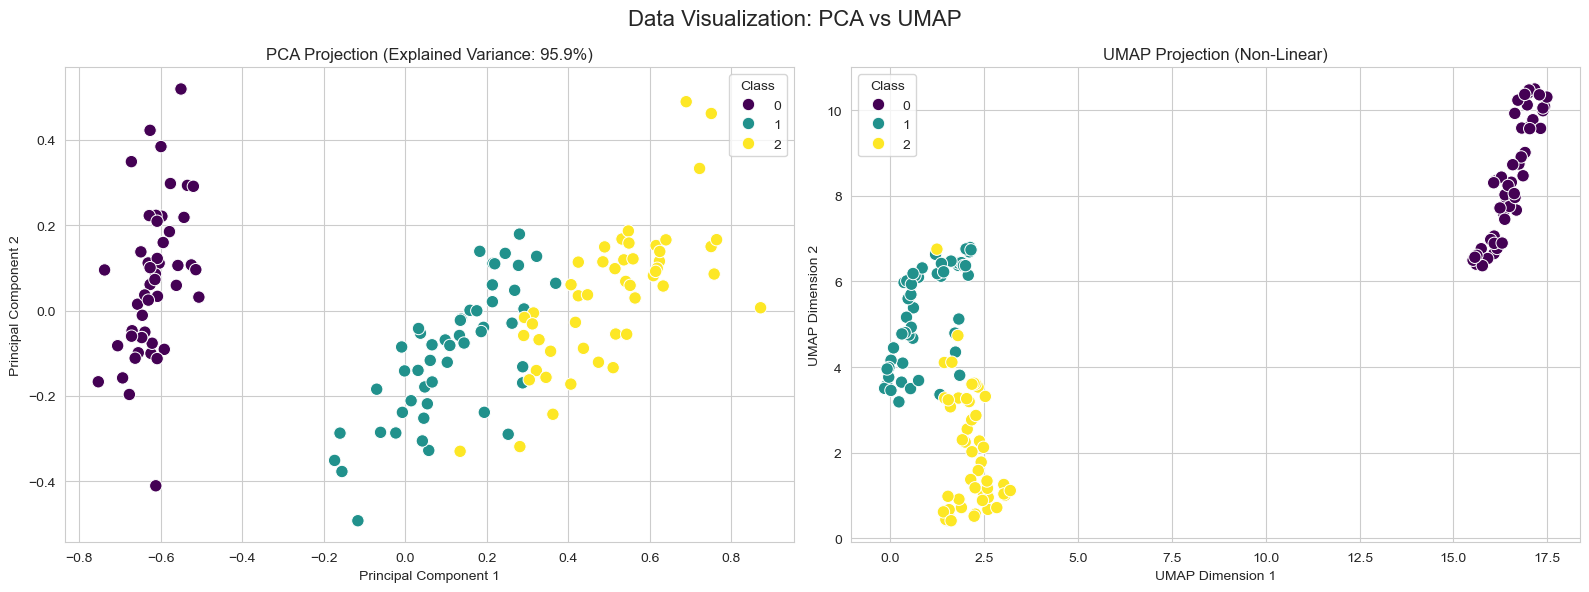

In [19]:
# --- EDA: Dimension Reduction Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap

# 1. Prepare Data for Plotting
# We use the scaled feature matrix 'X' and the target labels 'y'
targets = y['class'].values

# 2. PCA (Principal Component Analysis)
# PCA linearly projects the data to the directions of maximum variance.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_var = pca.explained_variance_ratio_.sum() * 100

# 3. UMAP (Uniform Manifold Approximation and Projection)
# UMAP is a non-linear technique better at preserving local neighborhood structure.
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

# 4. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=targets, palette='viridis', s=80, ax=axes[0])
axes[0].set_title(f'PCA Projection (Explained Variance: {pca_var:.1f}%)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend(title='Class')

# UMAP Plot
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=targets, palette='viridis', s=80, ax=axes[1])
axes[1].set_title('UMAP Projection (Non-Linear)')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].legend(title='Class')

plt.suptitle('Data Visualization: PCA vs UMAP', fontsize=16)
plt.tight_layout()
plt.savefig('pca_map.png', dpi=1024, bbox_inches='tight')
plt.show()

# Interpretation:
# If the classes are well-separated in these 2D plots, the problem is "easier" for the model.
# Overlap suggests the model needs non-linear boundaries (like those provided by the ANN).

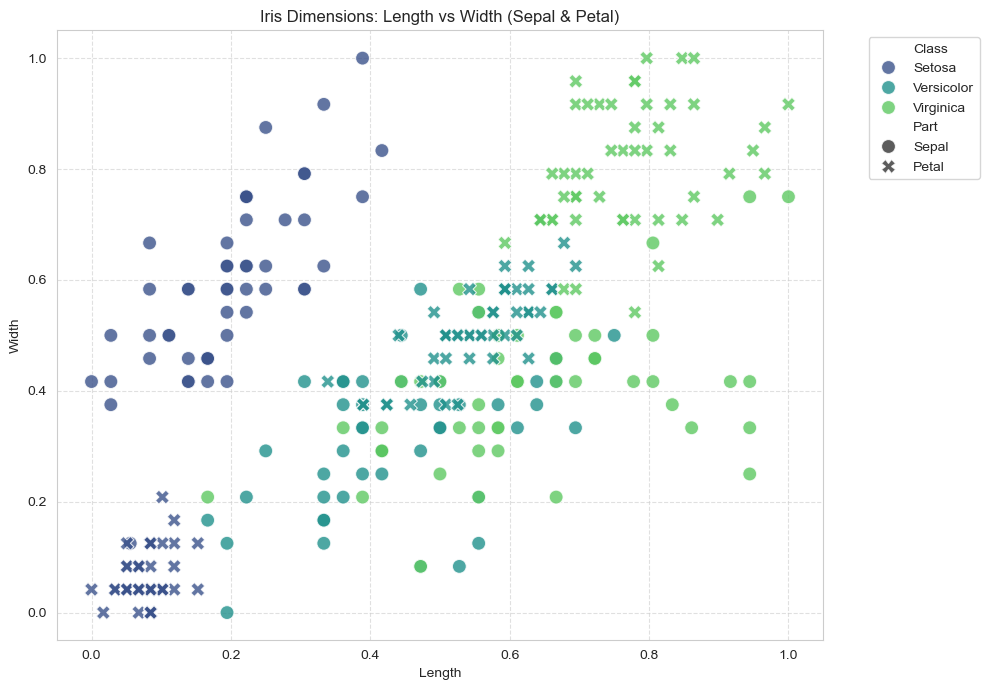

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Prepare Data for Plotting
# We assume 'X' is the feature DataFrame and 'y' contains the target class labels
# For this visualization, using the raw 'X' (unscaled) would be more interpretable
# if you want real units, but we'll use the existing 'X' from your context.

# Ensure we have the class names for the legend
class_map = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

# Create a clean DataFrame for manipulation
plot_df = X.copy()
plot_df['Class'] = y['class'].map(class_map)

# 2. Reshape to "Long" Format
# We want to stack Sepal and Petal data so we can plot them on the same axes.
# Current columns: 'sepal length', 'sepal width', 'petal length', 'petal width'

# Create Sepal subset
sepals = plot_df[['sepal length', 'sepal width', 'Class']].copy()
sepals.columns = ['Length', 'Width', 'Class']
sepals['Part'] = 'Sepal'

# Create Petal subset
petals = plot_df[['petal length', 'petal width', 'Class']].copy()
petals.columns = ['Length', 'Width', 'Class']
petals['Part'] = 'Petal'

# Combine
long_df = pd.concat([sepals, petals], axis=0).reset_index(drop=True)

# 3. Create Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=long_df,
    x='Length',
    y='Width',
    hue='Class',   # Color by Flower Species
    style='Part',  # Shape by Plant Part (Sepal/Petal)
    s=100,         # Marker size
    alpha=0.8,     # Transparency
    palette='viridis'
)

plt.title('Iris Dimensions: Length vs Width (Sepal & Petal)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('2dscatterplot.png', dpi=1024, bbox_inches='tight')
plt.show()

# Conclusion